# 1D Offshore Spectrum to Nearshore observations

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [2]:
oneD_Off = pd.read_csv('../data/spec1D_offshore.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')

<Axes: >

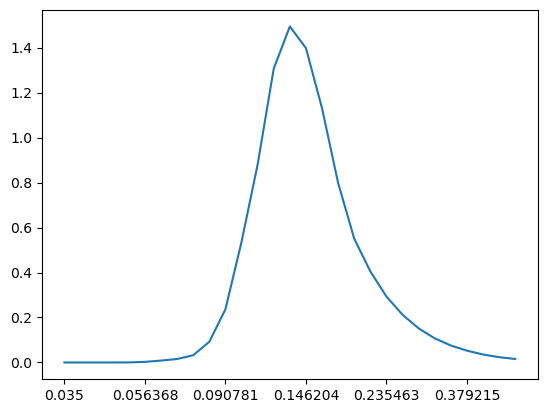

In [3]:
oneD_Off.iloc[0].plot()

We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [4]:
offStats = pd.read_csv("../data/stats_offshore.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats = offStats.drop(['lat', 'lon'], axis=1)

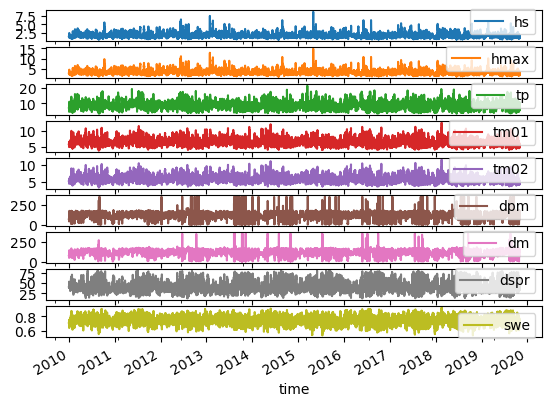

In [5]:
_ = offStats.plot(subplots = True)

## Read in Observational Data

Observational data is available from a number of sources we need to bring them together.

In [6]:
Obs = pd.read_csv('../data/obs_GC.csv', parse_dates = True, index_col = 0)
Obs.columns = ['hs','hmax','tp','tz','dp']

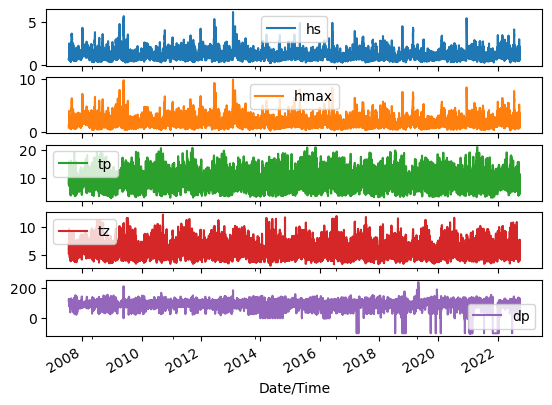

In [7]:
_ = Obs.plot(subplots = True)

# Feature Engineering

We need to merge our data together to create a dataset for model training.

In this step we also need to extract key features that will help the model when training.

In [8]:
new_columns = [column + '_tgt' for column in Obs.columns]
Obs = Obs.rename(columns=dict(zip(Obs.columns, new_columns)))

In [9]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, Obs, left_index=True, right_index=True)

<Axes: >

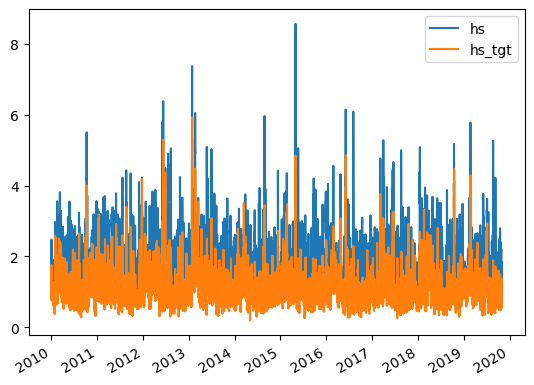

In [10]:
merged_df[['hs','hs_tgt']].plot()

**Time Based**

In [11]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [12]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [13]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [14]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt',
       'tp_tgt', 'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week',
       'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [15]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('Dir_Tp TRUE_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [16]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

## Keep some independent data

In [17]:
ind_data = merged_df["2019-06-01":]
merged_df  = merged_df["2015-01-01":"2019-06-01"]

## Selecting Training Data

In [18]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dspr', 'swe', 'hs_tgt', 'hmax_tgt', 'tp_tgt',
       'tz_tgt', 'dp_tgt', 'year', 'month', 'day', 'day_of_week', 'hour',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'dpm_sin', 'dpm_cos', 'dm_sin', 'dm_cos'],
      dtype='object')

In [19]:
features_col = ['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735',
       'month', 'day', 'hour']

In [20]:
labels_col = ['hs_tgt']

In [21]:
features = merged_df[features_col]
labels = merged_df[labels_col]

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [23]:
from sklearn.model_selection import TimeSeriesSplit

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [25]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels)
y_train = norm_l.transform(labels)

## Training

In [26]:
from sklearn.neural_network import MLPRegressor
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [27]:
X_train.shape[0]/2*(X_train.shape[1]+1)

421063.5

In [28]:
100**4

100000000

## Identify the best Model

Using gridsearch we need to attempt to find the best model parameters.

In [29]:
def find_best_model(features, labels, sample_size=10000):
    # Randomly sample a subset of the data
    #sampled_features, sampled_labels = resample(features, labels, n_samples=sample_size, random_state=42)
    sampled_features, sampled_labels = features[len(features) - sample_size:], labels[len(labels) - sample_size:]
    
    # Define the parameter grid for grid search
    param_grid = {
        'hidden_layer_sizes': [(50,50,50,50), (6,6,6), (10, 10, 10, 10), (100,100,100,100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [ 0.001, 0.01, 0.0001],
    }
    
    # Create the MLPRegressor model
    model = MLPRegressor(random_state=42)
    
    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(model, param_grid, scoring=['neg_root_mean_squared_error'], cv=TimeSeriesSplit(n_splits = 3), refit = 'neg_root_mean_squared_error')
    grid_search.fit(sampled_features, sampled_labels)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return best_model, best_params, best_score

In [30]:
best_model, best_params, best_score = find_best_model(features, labels, sample_size=4000)

# Print the best model and best parameters
print("Best Model:")
print(best_model)
print("\nBest Parameters:")
print(best_params)
print("\nBest Score:")
print(best_score)

/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_n

## Model Setup

In [ ]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = best_params['hidden_layer_sizes'],
                                             activation = best_params['activation'],
                                             solver = best_params['solver'],
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0,
                                             alpha =  best_params['alpha'])

clf_mlp2 = MLPRegressor(hidden_layer_sizes = (10, 10, 10, 10),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0,
                                             alpha =  0.001)

Timeseries training technique

In [ ]:
int(len(X_train)//48)

531

In [35]:
tscv = TimeSeriesSplit(n_splits=534)

In [36]:
for train_index, test_index in tscv.split(X_train):
    print()
    X__train_stream, X_test_stream = X_train[train_index, :], y_train[train_index, :]
    clf_mlp1.partial_fit(X__train_stream, X_test_stream.ravel())

Complete dataset technique

In [42]:
clf_mlp2.fit(X_train, y_train)

/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lpeach/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.001, early_stopping=True,
             hidden_layer_sizes=(10, 10, 10, 10), random_state=0,
             shuffle=False)

## Simple prediciton

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
hs_pred = norm_l.inverse_transform(pd.Series(clf_mlp1.predict(norm_f.transform(ind_data[features_col]))).values.reshape(-1,1))
hs_pred_alt = norm_l.inverse_transform(pd.Series(clf_mlp2.predict(norm_f.transform(ind_data[features_col]))).values.reshape(-1,1))

In [ ]:
prediction = pd.DataFrame(hs_pred, index = ind_data.index, columns = ['hs_tgt'])
prediction_alt = pd.DataFrame(hs_pred_alt, index = ind_data.index, columns = ['hs_tgt'])

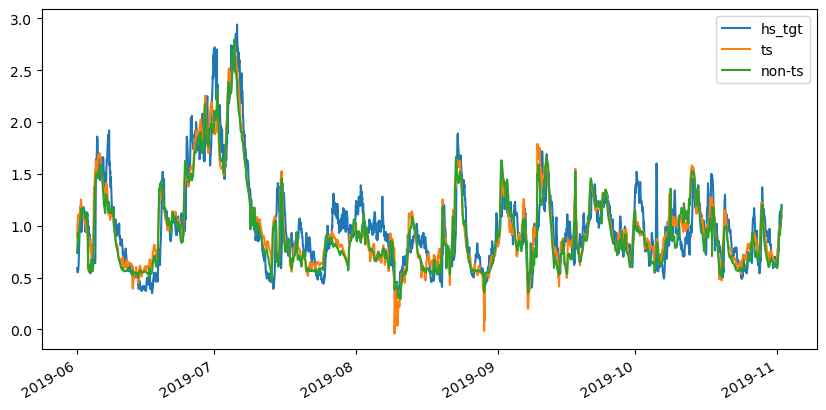

In [ ]:
plt.figure(figsize = (10, 5))
ind_data.hs_tgt.plot()
prediction.hs_tgt.plot(label = 'ts')
prediction_alt.hs_tgt.plot(label = 'non-ts')
plt.legend()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_columns(df1, df2):
    matching_columns = set(df1.columns) & set(df2.columns)
    results = pd.DataFrame(columns=['Column', 'RMSE', 'MSE', 'Bias', 'Correlation'])
    
    for column in matching_columns:
        values1 = df1[column].values
        values2 = df2[column].values
        
        rmse = np.sqrt(mean_squared_error(values1, values2))
        mse = mean_squared_error(values1, values2)
        bias = np.mean(values1 - values2)
        correlation = np.corrcoef(values1, values2)[0, 1]
        
        results = results.append({
            'Column': column,
            'RMSE': rmse,
            'MSE': mse,
            'Bias': bias,
            'Correlation': correlation
        }, ignore_index=True)
    
    return results

In [41]:
compare_columns(ind_data, prediction)

NameError: name 'prediction' is not defined

In [44]:
compare_columns(ind_data, prediction_alt)

/tmp/ipykernel_454/4055570356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Column,RMSE,MSE,Bias,Correlation
0,hs_tgt,0.222919,0.049693,0.054892,0.871396
